In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

# Load and Pre-Process the Data

In [2]:
df = pd.read_csv('../data/founder_V0.3_founder.csv')

In [3]:
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['Full_Name', 'Primary_Job_Title', 'Bio', 'Gender',
       'Number_of_News_Articles', 'Number_of_Founded_Organizations',
       'Number_of_Portfolio_Companies', 'Number_of_Investments_x',
       'Number_of_Partner_Investments', 'Number_of_Lead_Investments_x',
       'Number_of_Exits_x', 'Number_of_Events_x', 'Categories',
       'Headquarters_Location_', 'Operating_Status', 'Founded_Date',
       'Closed_Date', 'Company_Type', 'Number_of_Founders', 'Success',
       'Founder'],
      dtype='object')

In [4]:
df.shape

(18361, 21)

# Normalization

In [5]:
df['Number_of_News_Articles'] = df['Number_of_News_Articles']/df['Number_of_News_Articles'].max()

In [6]:
df['Number_of_Founded_Organizations'] = df['Number_of_Founded_Organizations']/df['Number_of_Founded_Organizations'].max()

In [7]:
df['Number_of_Portfolio_Companies'] = df['Number_of_Portfolio_Companies']/df['Number_of_Portfolio_Companies'].max()

In [8]:
df['Number_of_Investments_x'] = df['Number_of_Investments_x'] / df['Number_of_Investments_x'].max()

In [9]:
df['Number_of_Partner_Investments'] = df['Number_of_Partner_Investments'] /df['Number_of_Partner_Investments'].max()

In [10]:
df['Number_of_Lead_Investments_x'] = df['Number_of_Lead_Investments_x']/ df['Number_of_Lead_Investments_x'].max()

In [11]:
df['Number_of_Exits_x'] = df['Number_of_Exits_x'] / df['Number_of_Exits_x'].max()

In [12]:
df['Number_of_Events_x'] = df['Number_of_Events_x']/ df['Number_of_Events_x'].max()

Convert HQ Locations to Frequency of that Location Across the Dataset

In [13]:
hq_subset = df['Headquarters_Location_'].value_counts().reset_index(name = 'count').rename(columns = {'index':'Headquarters_Location_'})
hq_subset = pd.DataFrame(hq_subset)
print(hq_subset.head(10))


  Headquarters_Location_  count
0             California   6592
1               New York   1947
2         United Kingdom   1062
3                  India    934
4          Massachusetts    736
5                 Canada    503
6                Germany    449
7                 Israel    433
8                  Texas    337
9             Washington    322


In [14]:
df = pd.merge(df, hq_subset, on='Headquarters_Location_', how="left")
df.tail(5)

,Full_Name,Primary_Job_Title,Bio,Gender,Number_of_News_Articles,Number_of_Founded_Organizations,Number_of_Portfolio_Companies,Number_of_Investments_x,Number_of_Partner_Investments,Number_of_Lead_Investments_x,...,Categories,Headquarters_Location_,Operating_Status,Founded_Date,Closed_Date,Company_Type,Number_of_Founders,Success,Founder,count
18356,Glenn Shimkus,Co-founder & CEO,0,1,0.0,0.076923,0.0,0.0,0.0,0.0,...,"Document Management, Transaction Processing, R...",Illinois,1,2009,0,0,2,1,1,273
18357,Douglas Keszler,Co-Founder,0,1,0.0,0.076923,0.0,0.0,0.0,0.0,...,"Semiconductor, Electronics, Manufacturing",Oregon,1,2007,0,1,2,1,1,80
18358,Clark Johannson,Co-Founder & Chief Technology Officer,0,1,0.0,0.076923,0.0,0.0,0.0,0.0,...,"Peer to Peer, Construction, Social Network",Canada,1,2015,0,1,3,0,1,503
18359,Stefano Colonna,Founder,Digital serial entrepreneur. Founded and mana...,1,0.0,0.076923,0.0,0.0,0.0,0.0,...,"E-Commerce, Mobile, Mobile Payments",Massachusetts,1,2009,0,1,1,0,1,736
18360,Daniel Hoepfner,Founder,Daniel Hoepfner is founder and managing direct...,1,0.0,0.153846,0.0,0.0,0.0,0.0,...,"Content Marketing, Mobile, Publishing, Digital...",Germany,1,2011,0,1,2,0,1,449


In [15]:
# set Headquarters_Location_ equal to the count column
df['Headquarters_Location_'] = df['count']
df = df.drop(['count', 'Closed_Date', 'Full_Name', 'Founder', 'Bio', 'Categories'], axis = 1)
df['Gender'] = df['Gender'].astype(int)


In [16]:
df['Gender'].value_counts() # 131 people responded 2
index_names = df[df["Gender"] == 2].index
df.drop(index_names, inplace=True)

In [62]:
clean_df = pd.DataFrame(df)
clean_df.head(5)

,Primary_Job_Title,Gender,Number_of_News_Articles,Number_of_Founded_Organizations,Number_of_Portfolio_Companies,Number_of_Investments_x,Number_of_Partner_Investments,Number_of_Lead_Investments_x,Number_of_Exits_x,Number_of_Events_x,Headquarters_Location_,Operating_Status,Founded_Date,Company_Type,Number_of_Founders,Success
0,"Chairman, Product Architect & CEO",1,0.734069,0.538462,0.112245,0.187500,0.0,1.0,0.162162,0.074074,6592,1,2003,1,4,1
1,Co-Founder and CTO,1,0.005082,0.153846,0.010204,0.008929,0.0,0.0,0.000000,0.037037,6592,1,2003,1,4,1
2,Founder & CEO,1,1.000000,0.769231,0.061224,0.062500,0.0,0.0,0.000000,0.185185,6592,1,2004,1,5,1
3,Founder and VP of Product Strategy,1,0.006505,0.076923,0.061224,0.062500,0.0,0.0,0.027027,0.185185,6592,1,2006,1,2,1
4,Co-Founder & SVP of Finance Operations,1,0.043754,0.076923,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1947,1,2013,0,3,1


In [35]:
X = clean_df.drop(['Primary_Job_Title', 'Operating_Status', 'Company_Type', 'Success'], axis = 1)
y = clean_df['Success'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 1234)
X.shape


(18230, 12)

# XGBoost

In [37]:
xgb_classifier = xgb.XGBClassifier(n_estimators= 1000, objective='binary:logistic', booster='gbtree', learning_rate=.3, colsample_bytree=.3, reg_alpha= .3, random_state = 1234)
xgb_classifier.fit(x_train, y_train)
xgb_y_pred = xgb_classifier.predict(x_test)

xgb_train_score = round(xgb_classifier.score(x_train, y_train)*100, 3)
xgb_test_score = round(xgb_classifier.score(x_test, y_test)*100, 3)

print("Train Accuracy: " + str(xgb_train_score))
print("Test Accuracy: " + str(xgb_test_score))


Train Accuracy: 79.368
Test Accuracy: 77.153


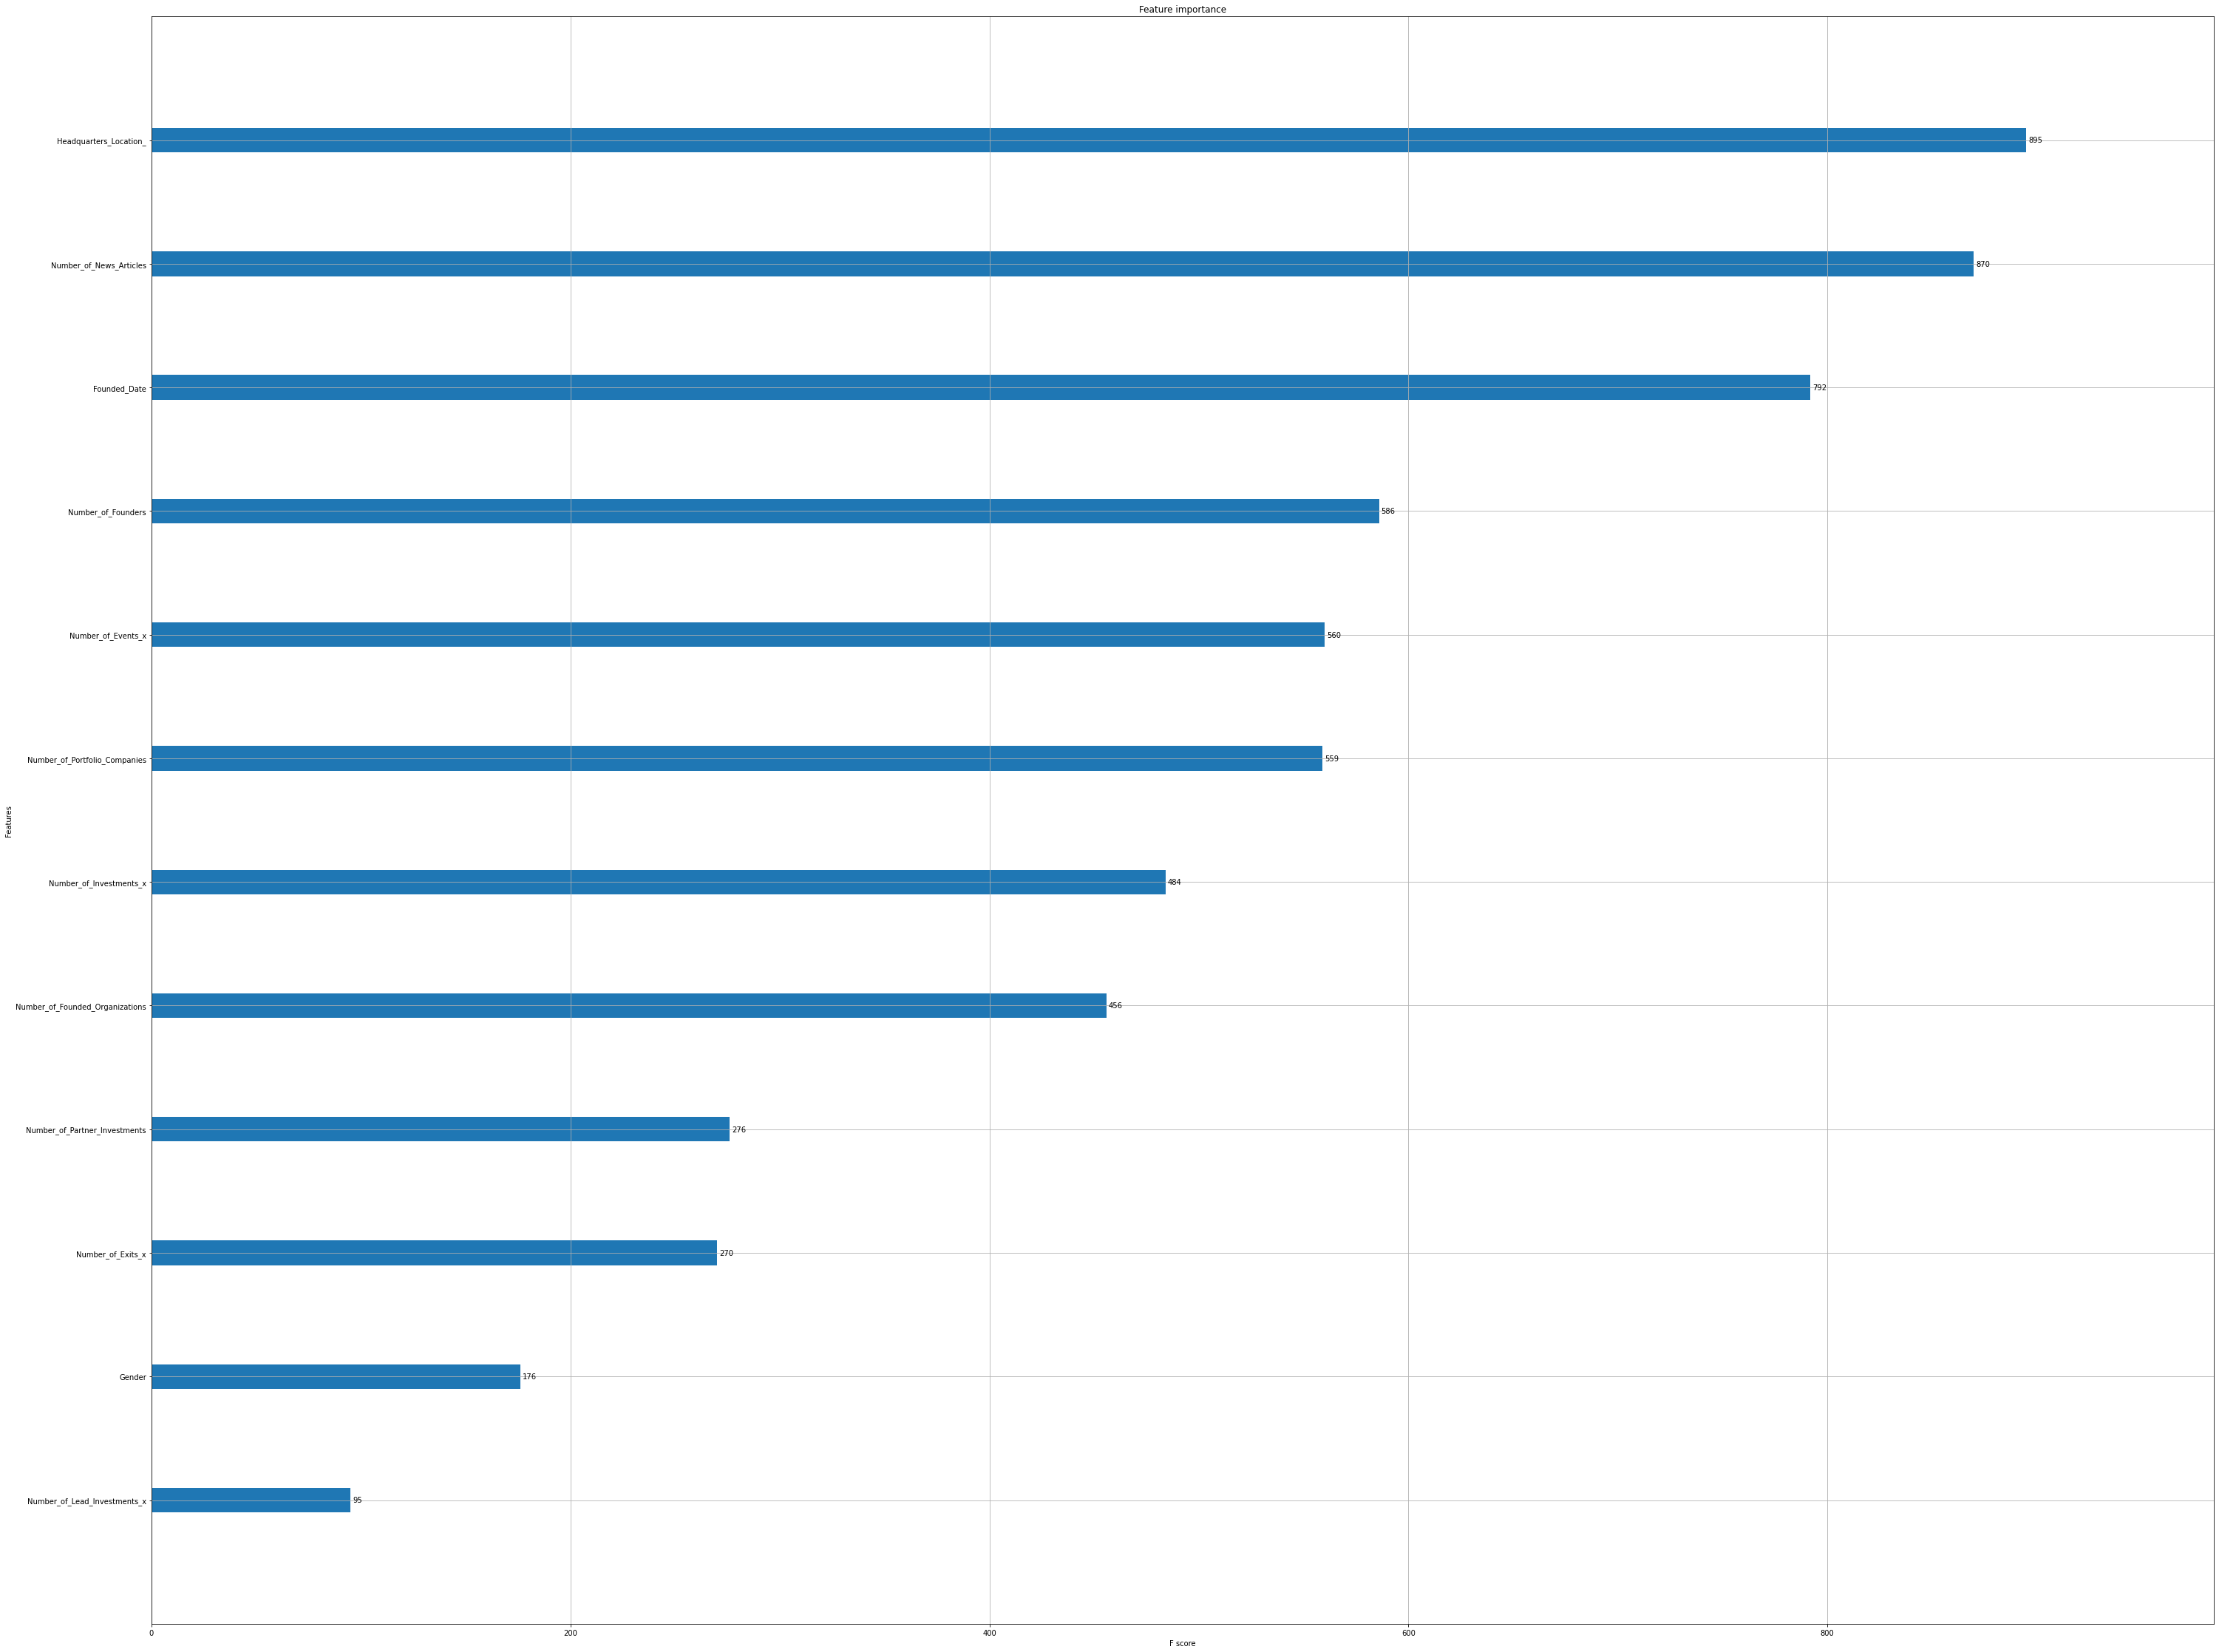

In [43]:
xgb.plot_importance(xgb_classifier)
plt.rcParams['figure.figsize'] = [50, 40]
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, xgb_y_pred))

print("RMSE: " + str(rmse))
print("MSE: " + str(mean_squared_error(y_test, xgb_y_pred)))

RMSE: 0.4779848906371986
MSE: 0.22846955567745475


# KNearestNeighbors

In [38]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors= 10, algorithm= 'auto', n_jobs=-1)

knn.fit(x_train, y_train)

knn_y_pred = knn.predict(x_test)

knn_train_score = round(knn.score(x_train, y_train)*100, 2)
knn_test_score = round(knn.score(x_test, y_test)*100, 2)

print(knn_train_score)
print(knn_test_score)


78.44
74.99


In [46]:
from sklearn.model_selection import cross_val_score 
k_neighbor = list(range(1, 50, 2))

cross_val_scores = []

for k in k_neighbor:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv = 10, scoring = 'accuracy')
    cross_val_scores.append(scores.mean())
print(cross_val_scores)

[0.7340926805006718, 0.7362868567549601, 0.7384110356135842, 0.7452685239246304, 0.7476690726214754, 0.7488349123880818, 0.7510290416327022, 0.7515769393133391, 0.754936156169878, 0.7551422935640943, 0.7552799378720227, 0.7556223562937954, 0.756857488311046, 0.7548002982293338, 0.7545944428931254, 0.7532227007806425, 0.7532915699442746, 0.7532912408765987, 0.7531544427426944, 0.7523316795332129, 0.7530858556370703, 0.7522630924275887, 0.752879859271858, 0.7517144425922635, 0.7526744270226615]


In [47]:
print(max(cross_val_scores))

0.756857488311046


In [51]:
misclassification_error = [1 - score for score in cross_val_scores]

best_k = k_neighbor[misclassification_error.index(min(misclassification_error))]
print(best_k)

25


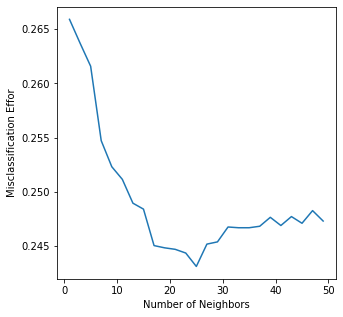

In [60]:
plt.plot(k_neighbor, misclassification_error)
plt.xlabel("Number of Neighbors")
plt.ylabel("Misclassification Effor")
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

# Random Forest

In [72]:
from sklearn.ensemble import RandomForestClassifier

rf_classification = RandomForestClassifier(n_estimators=int(np.sqrt(len(X.columns))))

rf_classification.fit(x_train, y_train)

rf_y_pred = rf_classification.predict(x_test)

rf_score_TEST = round(rf_classification.score(x_test, y_test)*100, 2)
rf_score_TRAIN = round(rf_classification.score(x_train, y_train)*100, 2)

print("Score on Training Data: " + str(rf_score_TRAIN))
print("Score on Testing Data: " + str(rf_score_TEST))


Score on Training Data: 89.23
Score on Testing Data: 74.38


# Gaussian Naive Bayes

In [83]:
from sklearn.naive_bayes import GaussianNB

gnb_clf = GaussianNB()
gnb_clf.fit(x_train, y_train)

gnb_y_pred = gnb_clf.predict(x_test)

gnb_score_TRAIN = round(gnb_clf.score(x_train, y_train)*100, 2)
gnb_score_TEST = round(gnb_clf.score(x_test, y_test)*100, 2)

print("{} Score on Training Data: ".format(str(gnb_clf.__class__.__name__)) + str(gnb_score_TRAIN))
print("{} Score on Testing Data: ".format(str(gnb_clf.__class__.__name__)) + str(gnb_score_TEST))

GaussianNB Score on Training Data: 44.42
GaussianNB Score on Testing Data: 43.61


# Decision Tree Classifier

In [87]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier()

dt_clf.fit(x_train, y_train)

dt_y_pred = dt_clf.predict(x_test)

dt_score_TRAIN = round(dt_clf.score(x_train, y_train)*100, 2)
dt_score_TEST = round(dt_clf.score(x_test, y_test)*100, 2)

print("{} TRAINING Score: ".format(str(dt_clf.__class__.__name__)) + str(dt_score_TRAIN))
print("{} TESTING Score: ".format(str(dt_clf.__class__.__name__)) + str(dt_score_TEST))


DecisionTreeClassifier TRAINING Score: 93.07
DecisionTreeClassifier TESTING Score: 74.25


# Log Regression

In [95]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression()

log_clf.fit(x_train, y_train)

log_y_pred = log_clf.predict(x_test)

log_score_TRAIN = round(log_clf.score(x_train, y_train)*100, 2)
log_score_TEST = round(log_clf.score(x_test, y_test)*100, 2)

print("{} TRAINING Score: ".format(str(log_clf.__class__.__name__)) + str(log_score_TRAIN))
print("{} TESTING Score: ".format(str(log_clf.__class__.__name__)) + str(log_score_TEST))


LogisticRegression TRAINING Score: 59.57
LogisticRegression TESTING Score: 60.78


# Ensemble Model

In [94]:
from sklearn.ensemble import VotingClassifier

rf_clf = RandomForestClassifier()
knn_clf = KNeighborsClassifier()
xgb_clf = xgb.XGBClassifier()
# dt_clf = DecisionTreeClassifier()

voting_clf = VotingClassifier(
    estimators= [('rf', rf_clf), ('knn', knn_clf), ('xgb', xgb_clf)],
    voting='soft' # more weight to highly confident votes
)

# voting_clf.fit(x_train, y_train)

# from sklearn.metrics import accuracy_score

for classifier in (rf_clf, knn_clf, xgb_clf, voting_clf):
    classifier.fit(x_train, y_train)
    y_pred = classifier.predict(x_test)
    print(classifier.__class__.__name__)
    print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
    print("RMSE: " + str(np.sqrt(mean_squared_error(y_test, y_pred))))
    print("MSE: " + str(mean_squared_error(y_test, y_pred)))
    print('\n\n')



RandomForestClassifier
Accuracy: 0.7613823368074603
RMSE: 0.4884850695697257
MSE: 0.23861766319253977



KNeighborsClassifier
Accuracy: 0.7468458584750411
RMSE: 0.5031442551842948
MSE: 0.25315414152495885



XGBClassifier
Accuracy: 0.7674163466812945
RMSE: 0.4822692746990061
MSE: 0.23258365331870542



VotingClassifier
Accuracy: 0.7816785518376302
RMSE: 0.4672488075558564
MSE: 0.21832144816236973



